In [27]:
import pandas

df = pandas.read_csv("topic-modeling-code/russia_ukraine_vk.csv")
df

,Unnamed: 0,tids,text,date,kind
0,0,9437184,"Ковид-паспорта уже действуют в Израиле , а в Е...",137,state-affiliated
1,1,34603009,⚡ ⚡ ⚡,441,state-affiliated
2,2,17825798,Данные по ковиду за сутки : https://life.ru/p/...,350,state-affiliated
3,3,38797325,В Twitter отреагировали на замедление работы в...,68,state-affiliated
4,4,31457294,Девочки снимали происходящее на телефон .,145,state-affiliated
...,...,...,...,...,...
577036,577036,1048549,Новости США за минуту : отправка войск в Польш...,400,independent
577037,577037,2097134,Уже больше года идет уголовный процесс против ...,411,independent
577038,577038,5242866,"Якутия в огне . Площадь пожаров превысила 1,5 ...",199,independent
577039,577039,1048563,В Ленинградской области управление ФСБ вызвало...,130,independent


In [28]:
translation = {"войны":"wars", "вторжения":"invasion","война":"war","войне":"war","войну":"war","вторжение":"invasion","операции":"operation","защите":"protection"}
war_frame_words = {
    "war":set([ "война", "войны", "войне", "войнам", "войну", "войной", "войною", "войнами", "войнах"]), 
    "operation":set(["операция", "операции", "операций", "операциям", "операцию", "операцией", "операциею", "операциями", "операциях"])
}


In [29]:
def str_isin_word_set(text: str, words: set):
    # determine if text contains any of the words in the set
    for word in words:
        # print("@", word, text)
        if word in text:
            return True
    return False

In [33]:
from tqdm.auto import tqdm

sub_df = df[['text', 'date', 'kind']].dropna()
print(sub_df.head())

results = []
word_set = war_frame_words['war'] | war_frame_words['operation']
print(word_set)
for index, row in tqdm(sub_df.iterrows()):
    if str_isin_word_set(row['text'], word_set):
        results.append({'kind': row['kind'], 'date': row['date']})
results = pandas.DataFrame(results)

                                                text  date              kind
0  Ковид-паспорта уже действуют в Израиле , а в Е...   137  state-affiliated
1                                              ⚡ ⚡ ⚡   441  state-affiliated
2  Данные по ковиду за сутки : https://life.ru/p/...   350  state-affiliated
3  В Twitter отреагировали на замедление работы в...    68  state-affiliated
4          Девочки снимали происходящее на телефон .   145  state-affiliated
{'операциям', 'войнах', 'войны', 'войною', 'операциями', 'операциях', 'операций', 'войну', 'операциею', 'операцию', 'войне', 'война', 'войнам', 'войнами', 'операция', 'операции', 'войной', 'операцией'}


0it [00:00, ?it/s]

In [49]:
# compute the number of posts for each date for each kind
cnt_df_war = results.groupby(['date', 'kind']).size()
cnt_df_all = sub_df.groupby(['date', 'kind']).size()
cnt_df = pandas.concat([cnt_df_war, cnt_df_all], axis=1, keys=['war', 'all'])
# set nan to 0, and set all to float
cnt_df = cnt_df.fillna(0).astype(float)
cnt_df['freq'] = cnt_df['war'] / cnt_df['all']
cnt_df

war    all      freq
date kind                                   
0    independent        3.0  137.0  0.021898
     state-affiliated   1.0  630.0  0.001587
1    independent        3.0  171.0  0.017544
     state-affiliated   3.0  625.0  0.004800
2    independent        4.0  175.0  0.022857
...                     ...    ...       ...
498  independent       43.0  151.0  0.284768
     state-affiliated  60.0  708.0  0.084746
499  independent       20.0  135.0  0.148148
     state-affiliated  38.0  675.0  0.056296
86   independent        0.0  194.0  0.000000

[1000 rows x 3 columns]

In [86]:
# given a column of date deltas and a reference date, compute the exact date of each row
def compute_date(deltas, reference_date):
    return pandas.to_datetime(reference_date) + pandas.to_timedelta(deltas, unit='d')

cnt_df['date_fmt'] = compute_date(cnt_df.index.get_level_values(0) - 500, '2022-05-15')
cnt_df

war    all      freq   date_fmt
date kind                                              
0    independent        3.0  137.0  0.021898 2020-12-31
     state-affiliated   1.0  630.0  0.001587 2020-12-31
1    independent        3.0  171.0  0.017544 2021-01-01
     state-affiliated   3.0  625.0  0.004800 2021-01-01
2    independent        4.0  175.0  0.022857 2021-01-02
...                     ...    ...       ...        ...
498  independent       43.0  151.0  0.284768 2022-05-13
     state-affiliated  60.0  708.0  0.084746 2022-05-13
499  independent       20.0  135.0  0.148148 2022-05-14
     state-affiliated  38.0  675.0  0.056296 2022-05-14
86   independent        0.0  194.0  0.000000 2021-03-27

[1000 rows x 4 columns]

In [98]:
cnt_df[cnt_df['date_fmt'] == '2021-01-01']

war    all      freq   date_fmt
date kind                                             
1    independent       3.0  171.0  0.017544 2021-01-01
     state-affiliated  3.0  625.0  0.004800 2021-01-01

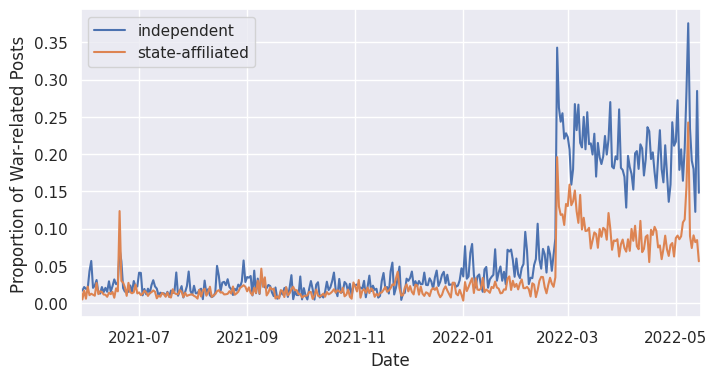

In [115]:
# seaborn plot density of dates
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
# from scipy.ndimage.filters import gaussian_filter1d

fig = plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
plt.ylabel("Proportion of War-related Posts")
plt.xlabel("Date")
# sns.scatterplot(data=cnt_df, x="date", y="freq", hue="kind")

g = sns.lineplot(data=cnt_df, x="date", y="freq", hue="kind")
g.legend_.set_title("")
# set x ticks to date stings
# 486: "2022-05-01", 425: "2022-03-01", 366: "2022-01-01", 305: "2021-11-01", 244: "2021-09-01", 183: "2021-07-01", 122: "2021-05-01", 60: "2021-03-01", 1: "2021-01-01"
plt.xticks(
    [486, 425, 366, 305, 244, 183, 122, 60, 1], 
    ["2022-05", "2022-03", "2022-01", "2021-11", "2021-09", "2021-07", "2021-05", "2021-03", "2021-01"],
    rotation=0,
)
plt.xlim(150, 500)
plt.show()
fig.savefig("fig3.pdf", bbox_inches='tight')